# `Russian Troll Tweets Part-03 NLP pre-processing`

# <font color=red>Mr Fugu Data Science</font>

# (◕‿◕✿)

<font size=5>**`Help Support Channel: Patreon @mrfugudatasci`**</font>
    
**`Or Consider: Buy Me A Coffee @mrfugudatasci`**

**PLEASE READ THIS:**

**`In order to use the CSV, you will need to start from the first notebook due to size of file`**

+ These are sequential videos doing steps to get to this point. You can directly download from Kaggle. I showed how to do this in a previous video. [Kaggle api](https://youtu.be/mmxbyfhG6Ss)

In [4]:
import pandas as pd
import numpy as np
import re

# plotting image with word cloud
from PIL import Image                    # for our images
import numpy as np                       # convert image to np arrays
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS # generate word cloud
import matplotlib.pyplot as plt          # plotting
import seaborn as sns

# nlp
import nltk                              # text processing
from nltk import word_tokenize           # split sentence into list of words
from nltk.corpus import stopwords        # remove: and,it,i,etc
import string                            # remove punctuation
from collections import defaultdict      # dictionary with values as lists
from nltk.stem import WordNetLemmatizer  # remove word endings etc

%matplotlib inline

In [276]:
troll_02=pd.read_csv('troll_tweets_vid02.csv')

troll_02=troll_02.drop(['content','Unnamed: 0'],axis = 1)

troll_02.tail()

,author,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,content without http
2973365,_YOUR_LIFESTYLE,Unknown,Uzbek,9/7/2015 1:31,60,4,412,Other_Tweet,Russian,0,NonEnglish,Санкционный пинг-понг
2973366,_YOUR_LIFESTYLE,Unknown,Russian,9/8/2015 14:49,60,4,416,Other_Tweet,Russian,0,NonEnglish,Горизонтальный кальян NanoSmoke
2973367,_YOUR_LIFESTYLE,Unknown,Russian,9/9/2015 18:52,60,4,418,Other_Tweet,Russian,0,NonEnglish,Фотограф Kai-Hendrik Schroeder
2973368,_YOUR_LIFESTYLE,Unknown,Russian,9/9/2015 22:26,60,4,419,Other_Tweet,Russian,0,NonEnglish,К чему стремится компания Netflix (США)
2973369,_YOUR_LIFESTYLE,Unknown,Russian,9/9/2015 8:17,60,4,417,Other_Tweet,Russian,0,NonEnglish,В Петербурге появилось вегетарианское кафе в к...


# We need to do some formatting of these data for NLP!

+ Depending on our analysis dictates what we do...

In [278]:
round(troll_02['retweet'].mean(),3)

# troll_02['publish_date']=pd.to_datetime(troll_02['publish_date'],
#                                         infer_datetime_format=True)

# troll_02['publish_date'].\
# dt.strftime('%H')

0          19:58
1          22:43
2          22:50
3          23:52
4          02:13
           ...  
2973365    01:31
2973366    14:49
2973367    18:52
2973368    22:26
2973369    08:17
Name: publish_date, Length: 2973370, dtype: object

In [279]:
# Convert str to date/time with pandas
troll_02['publish_date']=pd.to_datetime(troll_02['publish_date'],
                                        infer_datetime_format=True)

troll_02.sort_values('publish_date',ascending=True)

# Change formating to US dates
troll_02['publish_date_Only']=troll_02['publish_date'].\
dt.strftime('%m/%d/%Y')

troll_02['time']=troll_02['publish_date'].\
dt.strftime('%H')


In [280]:
troll_02['publish_date_Only']=pd.to_datetime(troll_02['publish_date_Only'],
                                        infer_datetime_format=True)

# get range to encapsulate before and after election 2016
mask = (troll_02['publish_date_Only'] > '08/31/2016') &\
(troll_02['publish_date_Only']  <= '01/01/02017')


In [281]:

troll_dt_rng=troll_02[troll_02["publish_date_Only"].isin(pd.date_range('2016-10-01', '2017-01-01'))].\
sort_values('publish_date_Only')

In [282]:
troll_02.loc[7,'content without http']

'@SenatorMenendez @CarmenYulinCruz Doesnt matter that CNN doesnt report on your crimes. This wont change the fact that youre going down.'

# `Create Hashtag and Retweet columns:`

We have some simple solutions but there are issues:
This works but provides us with only first occurence `troll_02['content without http'].str.extract(r'@(\S+)')`

If we need a to find more: use `.extractall()` unfortunately it returns multi-index table and difficult to use.

Therefore, I used a loop to deal with this. Unless, you have a good work around beaware of limitations as well as your options.

In [283]:
# Use this to parse Hashtags and @user

def tweet_col_regx(df_col,re_pat):
    q=[]
    for i in df_col:
        if type(i)==str and re.findall(re_pat,i):
            q.append(re.findall(re_pat,i))
        else:
            q.append('None')
    return q

In [284]:
tweet_ref=tweet_col_regx(troll_dt_rng['content without http'],r'@(\S+)')

troll_dt_rng['tweet_ref']=tweet_ref

In [285]:

hashtag_ref=tweet_col_regx(troll_dt_rng['content without http'],r'#(\S+)')

troll_dt_rng['hashtag_ref']=hashtag_ref

In [286]:
# troll_dt_rng[troll_dt_rng['tweet_ref']!='None'] #verify it is working in this column

In [287]:
# convert author/user name to lowercase for comparisons
troll_dt_rng['author']=troll_dt_rng['author'].map(lambda x: x.lower())


In [288]:

troll_dt_rng.head(9)


user_list = troll_dt_rng['author'].unique()

#Define a function to test whether a value is part
# of the authors (for apply function below)
def test_in(el):
    return (el in user_list)

#create a new column in tweets indicating whether the source 
# of a retweeted tweet was in our list of user_names

troll_dt_rng[troll_dt_rng['tweet_ref'].apply(test_in)==True].tail()

/Users/zatoichi59/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


,author,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,content without http,publish_date_Only,time,tweet_ref,hashtag_ref
2670625,todayinsyria,United Kingdom,English,2016-12-28 07:26:00,9397,28748,11341,Other_Tweet,news,0,NewsFeed,@todayinsyria its unknown whether he was suppl...,2016-12-28,07,[todayinsyria],[ISIS]
2670682,todayinsyria,United Kingdom,English,2016-12-29 08:31:00,7888,28798,11376,Other_Tweet,news,0,NewsFeed,@todayinsyria more than 20 fighters from both ...,2016-12-29,08,[todayinsyria],None
2670663,todayinsyria,United Kingdom,English,2016-12-29 13:25:00,7888,28813,11392,Other_Tweet,news,0,NewsFeed,@todayinsyria Iraqi security forces have liber...,2016-12-29,13,[todayinsyria],[Mosul]
2665847,todayinsyria,United Kingdom,English,2017-01-01 13:29:00,7391,28783,11419,Other_Tweet,news,0,NewsFeed,@todayinsyria #ISIS releases pictures of bombe...,2017-01-01,13,[todayinsyria],[ISIS]
2665850,todayinsyria,United Kingdom,English,2017-01-01 13:53:00,7390,28779,11422,Other_Tweet,news,0,NewsFeed,@todayinsyria #SAA artillery pounded #ISIS mil...,2017-01-01,13,[todayinsyria],"[SAA, ISIS]"


In [289]:
# Friend To Follower Ratios: 
troll_dt_rng['follower_to_following_Ratio']=np.where(troll_dt_rng['followers']/\
                        troll_dt_rng['following']==np.inf
                     , troll_dt_rng['followers'], 
         troll_dt_rng['followers']/troll_dt_rng['following'])


print('Proportion of Users w/ High Follower Count (ALL-SUBset data):',\
round(troll_dt_rng[troll_dt_rng['follower_to_following_Ratio']>2].shape[0]/\
troll_dt_rng[troll_dt_rng['follower_to_following_Ratio']<2].shape[0],3))

Proportion of Users w/ High Follower Count (ALL-SUBset data): 0.358


In [290]:
troll_dt_rng.sort_values('follower_to_following_Ratio',ascending=False)[:10]

,author,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,content without http,publish_date_Only,time,tweet_ref,hashtag_ref,follower_to_following_Ratio
1487417,kadirovrussia,Unknown,Russian,2016-12-07 07:55:00,0,95629,11191,Other_Tweet,Russian,0,NonEnglish,Лично договорился?,2016-12-07,07,None,None,95629.0
1429375,jenn_abrams,United States,English,2016-12-07 07:45:00,0,63581,21385,QUOTE_TWEET,Right,1,RightTroll,"Guys, I got blocked, something is wrong with T...",2016-12-07,07,None,None,63581.0
1429376,jenn_abrams,United States,English,2016-12-07 07:49:00,0,63580,21386,Other_Tweet,Right,0,RightTroll,@Trump_Row @PatriotTrumpet ✋�,2016-12-07,07,"[Trump_Row, PatriotTrumpet]",None,63580.0
1429374,jenn_abrams,United States,English,2016-12-07 07:43:00,0,63578,21383,Other_Tweet,Right,0,RightTroll,@SandyGraves7 @NYCdeb8tr Im not a trump supporter,2016-12-07,07,"[SandyGraves7, NYCdeb8tr]",None,63578.0
1944157,novostiekb,Unknown,Russian,2016-11-29 13:32:00,0,45230,9209,Other_Tweet,Russian,0,NonEnglish,В Екатеринбурге открылся голубиный ресторан,2016-11-29,13,None,None,45230.0
1969071,novostiomska,Unknown,Russian,2016-11-14 04:32:00,0,40273,7392,Other_Tweet,Russian,0,NonEnglish,Обещанный к 300-летию Омска кинотеатр Первомай...,2016-11-14,04,None,[Омск],40273.0
686822,crystal1johnson,United States,English,2016-12-08 01:57:00,0,25443,3091,Other_Tweet,left,0,LeftTroll,"My job during my season is to provide cheer, j...",2016-12-08,01,None,None,25443.0
686823,crystal1johnson,United States,English,2016-12-08 01:58:00,0,25443,3092,QUOTE_TWEET,left,1,LeftTroll,Black Santa is the greatest!,2016-12-08,01,None,None,25443.0
384865,boeing_is_back,Malaysia,Russian,2016-10-17 10:01:00,0,24235,3036,Other_Tweet,Russian,0,NonEnglish,"Все, что вы хотели знать о сыре, но боялись сп...",2016-10-17,10,None,None,24235.0
1938044,novostidamask,Unknown,Russian,2016-12-06 16:02:00,0,21463,10342,Other_Tweet,Russian,0,NonEnglish,Российские военные доставили гуманитарную помо...,2016-12-06,16,None,None,21463.0


# `Check fraction of tweets as retweets:`

In [291]:
# Subset English: 

eng_subset=troll_dt_rng[troll_dt_rng['language']=='English']
eng_subset.head()

,author,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,content without http,publish_date_Only,time,tweet_ref,hashtag_ref,follower_to_following_Ratio
2299654,richmondvoice,United States,English,2016-10-01 13:49:00,4731,2811,4778,Other_Tweet,local,0,NewsFeed,Chesterfield County Police respond to a wareho...,2016-10-01,13,None,None,0.594166
2299655,richmondvoice,United States,English,2016-10-01 14:16:00,4731,2811,4779,Other_Tweet,local,0,NewsFeed,Petersburg Police investigating after deadly s...,2016-10-01,14,None,None,0.594166
2299656,richmondvoice,United States,English,2016-10-01 15:03:00,4731,2811,4781,Other_Tweet,local,0,NewsFeed,Flint Residents On Federal Aid Deal: Too Littl...,2016-10-01,15,None,None,0.594166
2299657,richmondvoice,United States,English,2016-10-01 15:06:00,4731,2811,4782,Other_Tweet,local,0,NewsFeed,Mob informant trades witness protection for $1...,2016-10-01,15,None,None,0.594166
2299658,richmondvoice,United States,English,2016-10-01 15:33:00,4731,2811,4783,Other_Tweet,local,0,NewsFeed,Man found dead outside Petersburg home,2016-10-01,15,None,None,0.594166


In [292]:
pd.set_option('mode.chained_assignment', None) # ignore pandas warning: 
# "A value is trying to be set on a copy of a slice from a DataFrame"

print('Proportion of Users w/ High Follower Count (ENGLISH):',\
round(eng_subset[eng_subset['follower_to_following_Ratio']>2].shape[0]/\
eng_subset['follower_to_following_Ratio'].shape[0],3))

Proportion of Users w/ High Follower Count (ENGLISH): 0.174


In [293]:
# Subset Russian:

russ_subset=troll_dt_rng[troll_dt_rng['language']=='Russian']
russ_subset.head()

,author,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,content without http,publish_date_Only,time,tweet_ref,hashtag_ref,follower_to_following_Ratio
2857939,whitehousecards,United States,Russian,2016-10-01 10:06:00,3974,7927,722,Other_Tweet,Russian,0,NonEnglish,На Newsweek были совершены кибератаки после то...,2016-10-01,10,None,None,1.994716
1980409,novostispb,Russian Federation,Russian,2016-10-01 17:05:00,8732,105448,38355,Other_Tweet,Russian,0,NonEnglish,"Ёжик, блуждая в тумане, забрёл в #Петербург. К...",2016-10-01,17,None,[Петербург.],12.076042
1980408,novostispb,Russian Federation,Russian,2016-10-01 14:00:00,8731,105447,38353,Other_Tweet,Russian,0,NonEnglish,Так выглядела Сенная площадь в далеком 1933 году,2016-10-01,14,None,None,12.077311
1980407,novostispb,Russian Federation,Russian,2016-10-01 13:00:00,8731,105447,38352,Other_Tweet,Russian,0,NonEnglish,Очень актуальная инструкция для Петербурга - к...,2016-10-01,13,None,None,12.077311
1980406,novostispb,Russian Federation,Russian,2016-10-01 12:00:00,8731,105448,38350,Other_Tweet,Russian,0,NonEnglish,Друзья! Предлагаем Вам небольшую задачку � И н...,2016-10-01,12,None,None,12.077425


In [294]:
pd.set_option('mode.chained_assignment', None) # ignore pandas warning: 
# "A value is trying to be set on a copy of a slice from a DataFrame"

print('Proportion of Users w/ High Follower Count (RUSSIAN):',\
round(russ_subset[russ_subset['follower_to_following_Ratio']>2].shape[0]/\
russ_subset['follower_to_following_Ratio'].shape[0],3))

Proportion of Users w/ High Follower Count (RUSSIAN): 0.534


In [295]:

print('Subset Proportion Retweets:',round(troll_dt_rng['retweet'].mean(),3))
print('-----------------------')
print('English Subset fraction Retweets:',round(eng_subset['retweet'].mean(),3))
print('-----------------------')
print('Russian Subset fraction Retweets:',round(russ_subset['retweet'].mean(),3))

Subset Proportion Retweets: 0.723
-----------------------
English Subset fraction Retweets: 0.738
-----------------------
Russian Subset fraction Retweets: 0.675


# Top Russian & English Users by Number of Followers/Following Ratio:

+ People with the most influence. 
    + But, doesn't mean they are the ones doing the retweeting.

In [296]:
russ_subset.sort_values('follower_to_following_Ratio',ascending=False)[:500]['author'].unique()

array(['kadirovrussia', 'novostiekb', 'novostiomska', 'boeing_is_back',
       'novostidamask', 'novostiputin', 'novostishoigu', 'vestizakharova',
       'novostidyumin', 'novostivolodin'], dtype=object)

In [297]:
eng_subset.sort_values('follower_to_following_Ratio',ascending=False)[:500]['author'].unique()

array(['jenn_abrams', 'crystal1johnson', 'blacktolive', 'maxdementiev',
       'sergbriantsev', 'manzal_', 'kotovamarys', 'russilanrogov',
       'maksblaginin'], dtype=object)

# `Check Who Comes Up The Most for Reteeting:`

In [298]:
# Engl

eng_subset[eng_subset['retweet']==1]['author'].value_counts()[:10]

ameliebaldwin      11097
hyddrox             5389
javonhidp           5135
brianaregland       5056
worldofhashtags     4792
chrixmorgan         4592
pamblmdaniels       3906
alecmooooody        3398
jadonhutchinson     3150
mrclydepratt        2775
Name: author, dtype: int64

In [299]:
eng_ppl=list(eng_subset[eng_subset['retweet']==1]['author'].value_counts()[:10].index)

e=[]
for i in eng_ppl:
    e.append(eng_subset[(eng_subset['retweet']==1)&\
    (eng_subset['author']==i)]['author'].value_counts()/\
    eng_subset[eng_subset['author']==i].shape[0])

e

[ameliebaldwin    0.997125
 Name: author, dtype: float64,
 hyddrox    0.992084
 Name: author, dtype: float64,
 javonhidp    1.0
 Name: author, dtype: float64,
 brianaregland    1.0
 Name: author, dtype: float64,
 worldofhashtags    0.98358
 Name: author, dtype: float64,
 chrixmorgan    0.865109
 Name: author, dtype: float64,
 pamblmdaniels    1.0
 Name: author, dtype: float64,
 alecmooooody    1.0
 Name: author, dtype: float64,
 jadonhutchinson    1.0
 Name: author, dtype: float64,
 mrclydepratt    1.0
 Name: author, dtype: float64]

In [300]:
# Top 10 Russians by retweets:
russ_subset[russ_subset['retweet']==1]['author'].value_counts()[:10]

valeyina_dm       4089
denn_nikitin      3723
med_harley        3141
moda_barina       1859
rusnevrotik       1858
ttlenlen          1810
_beglov           1388
milimillennium    1345
alexharritonov    1290
vasilichvasili    1246
Name: author, dtype: int64

In [301]:
# Proportion of their total tweets being retweets:
russ_ppl=list(russ_subset[russ_subset['retweet']==1]['author'].value_counts()[:10].index)

r=[]
for i in russ_ppl:
    r.append(russ_subset[(russ_subset['retweet']==1)&\
    (russ_subset['author']==i)]['author'].value_counts()/\
russ_subset[russ_subset['author']==i].shape[0])

r

[valeyina_dm    0.998291
 Name: author, dtype: float64,
 denn_nikitin    0.998927
 Name: author, dtype: float64,
 med_harley    0.99746
 Name: author, dtype: float64,
 moda_barina    0.997318
 Name: author, dtype: float64,
 rusnevrotik    0.998925
 Name: author, dtype: float64,
 ttlenlen    0.998345
 Name: author, dtype: float64,
 _beglov    1.0
 Name: author, dtype: float64,
 milimillennium    1.0
 Name: author, dtype: float64,
 alexharritonov    0.999225
 Name: author, dtype: float64,
 vasilichvasili    0.999198
 Name: author, dtype: float64]

# `Check The Top 10 Tweets`

+ Illustrate how this tweet network is working
+ Show the people from top down trickling tweets 
    + Understand what is being said and how the information is flowing
    
    
**`Workflow:`**

+ Get unique names of top 20 authors who retweet
    + subset columns we need
    + only take rows that are retweeted
    + sort by author then time
+ Iterate through the authors and get a value count of each hour they tweet and create a list.
    + within this list we will have:
        + index of author names, this will be multiplied by the length of our output which is the number of rows we created in the value counts. Each author will have specific number of rows: (hour_tweet, count) not all users tweet through the day.
        + In the end we want the name, hour, number of tweets as a tuple
+ output will be a list of tuples, we need to take those and find missing hours and make a new list so everyone has 24 hrours and any missing values will have a zero for count

In [710]:
eng_ppl_exp=list(eng_subset[eng_subset['retweet']==1]['author'].\
                 value_counts()[:20].index)

top_10_retweeters=eng_subset[eng_subset['author'].isin(eng_ppl_exp)]

top_10=top_10_retweeters.loc[:,['author','time','content without http','retweet']]
 
top_10=top_10[top_10['retweet']==1]


top_10=top_10.sort_values(['author','time'])
top_10

val_cnts_authors_by_hr=[]
for i in eng_ppl_exp:
    val_cnts_authors_by_hr.extend(list(zip(len(top_10[top_10['author']==i]['time'].\
                            value_counts().index)*[i],
                            top_10[top_10['author']==i]['time'].value_counts().index,
    top_10[top_10['author']==i]['time'].value_counts())))

    
val_cnts_authors_by_hr[0:23]

[('ameliebaldwin', '03', 561),
 ('ameliebaldwin', '12', 560),
 ('ameliebaldwin', '18', 521),
 ('ameliebaldwin', '17', 519),
 ('ameliebaldwin', '21', 510),
 ('ameliebaldwin', '16', 507),
 ('ameliebaldwin', '01', 506),
 ('ameliebaldwin', '22', 497),
 ('ameliebaldwin', '20', 494),
 ('ameliebaldwin', '07', 494),
 ('ameliebaldwin', '23', 469),
 ('ameliebaldwin', '15', 461),
 ('ameliebaldwin', '02', 458),
 ('ameliebaldwin', '08', 439),
 ('ameliebaldwin', '13', 438),
 ('ameliebaldwin', '19', 437),
 ('ameliebaldwin', '04', 435),
 ('ameliebaldwin', '14', 434),
 ('ameliebaldwin', '10', 417),
 ('ameliebaldwin', '06', 417),
 ('ameliebaldwin', '05', 406),
 ('ameliebaldwin', '00', 396),
 ('ameliebaldwin', '11', 367)]

# `Checking Each List for Length 24:`

+ Lists of users < 24 means they don't have 24 hours in their list and we fix:
    + by using a set difference of hrs and create a new lists matching each user (name,hour_missing,0)
+ a dataframe is created with the above data and a second dataframe with our missing info and appended together, then sorted

In [713]:
jj=[]
for i in eng_ppl_exp:
    if len(top_10[top_10['author']==i]['time'].unique())<24:
        q=set(top_10['time'].unique())-\
        set(list(top_10[top_10['author']==i]['time'].unique()))
        jj.extend(list(zip([i]*len(q),list(q),len(q)*[0])))        

A=pd.DataFrame(jj,columns=['author','time','value'])
B=pd.DataFrame(val_cnts_authors_by_hr,columns=['author','time','value'])

user_by_hr_cnt=A.append(B)


user_by_hr_cnt.sort_values(['author','time'])

,author,time,value
140,alecmooooody,00,173
147,alecmooooody,01,150
156,alecmooooody,02,111
152,alecmooooody,03,130
154,alecmooooody,04,117
...,...,...,...
9,worldofhashtags,19,0
10,worldofhashtags,20,0
6,worldofhashtags,21,0
17,worldofhashtags,22,0


# `Heat Map Cluster: Find Tweeting Trends of Users By Hour`

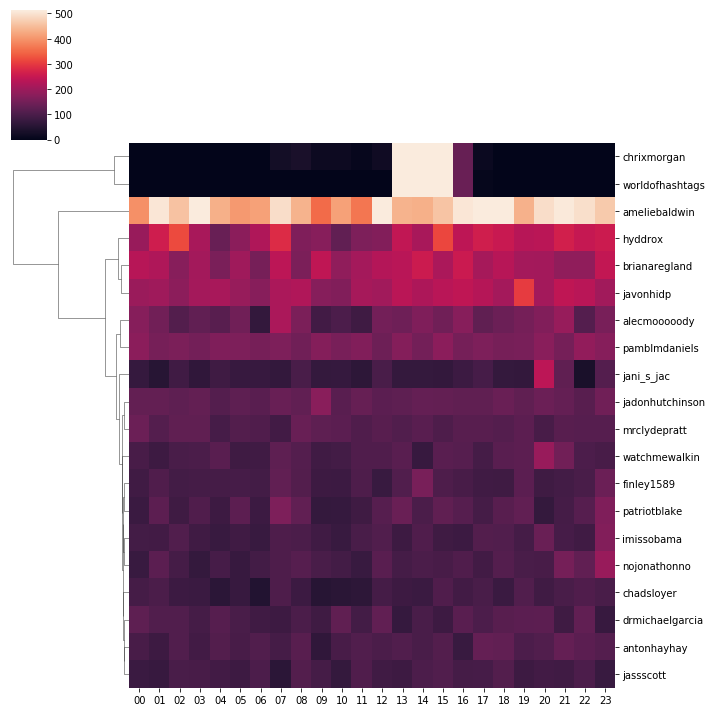

In [736]:
from collections import defaultdict

store_hr_cnts=defaultdict(list)

for i in user_by_hr_cnt.sort_values(['author','time']).values:
    store_hr_cnts[i[1]].append(i[2])
    
d1=pd.DataFrame(store_hr_cnts,index=sorted(user_by_hr_cnt['author'].unique()))

# I am trying to preserve the HR ordering
sns.clustermap(d1,col_cluster=False,robust=True) 

# `Now Same thing for Russian Retweeters:` <font size=8> 🇷🇺</font>


In [728]:
russ_ppl_exp=list(russ_subset[russ_subset['retweet']==1]['author'].\
                 value_counts()[:20].index)

top_10_retweeters_russ=russ_subset[russ_subset['author'].isin(russ_ppl_exp)]

top_10_russ=top_10_retweeters_russ.\
loc[:,['author','time','content without http','retweet']]
 
top_10_russ=top_10_russ[top_10_russ['retweet']==1]


top_10_russ=top_10_russ.sort_values(['author','time'])
top_10_russ

val_cnts_authors_by_hr_russ=[]
for i in russ_ppl_exp:
    val_cnts_authors_by_hr_russ.\
    extend(list(zip(len(top_10_russ[top_10_russ['author']==i]['time'].\
                            value_counts().index)*[i],
                            top_10_russ[top_10_russ['author']==i]['time'].\
                    value_counts().index,
    top_10_russ[top_10_russ['author']==i]['time'].value_counts())))

    
val_cnts_authors_by_hr_russ[0:23]

[('valeyina_dm', '09', 195),
 ('valeyina_dm', '03', 193),
 ('valeyina_dm', '20', 192),
 ('valeyina_dm', '04', 192),
 ('valeyina_dm', '19', 188),
 ('valeyina_dm', '14', 186),
 ('valeyina_dm', '11', 184),
 ('valeyina_dm', '12', 183),
 ('valeyina_dm', '21', 182),
 ('valeyina_dm', '07', 180),
 ('valeyina_dm', '15', 177),
 ('valeyina_dm', '13', 175),
 ('valeyina_dm', '10', 174),
 ('valeyina_dm', '22', 172),
 ('valeyina_dm', '08', 170),
 ('valeyina_dm', '05', 167),
 ('valeyina_dm', '23', 165),
 ('valeyina_dm', '17', 165),
 ('valeyina_dm', '18', 159),
 ('valeyina_dm', '01', 143),
 ('valeyina_dm', '00', 142),
 ('valeyina_dm', '16', 142),
 ('valeyina_dm', '06', 132)]

In [729]:
jj_russ=[]
for i in russ_ppl_exp:
    if len(top_10_russ[top_10_russ['author']==i]['time'].unique())<24:
        q_r=set(top_10_russ['time'].unique())-\
        set(list(top_10_russ[top_10_russ['author']==i]['time'].unique()))
        jj_russ.extend(list(zip([i]*len(q_r),list(q_r),len(q_r)*[0])))        

A_r=pd.DataFrame(jj_russ,columns=['author','time','value'])
B_r=pd.DataFrame(val_cnts_authors_by_hr_russ,columns=['author','time','value'])

user_by_hr_cnt_russ=A_r.append(B_r)


user_by_hr_cnt_russ.sort_values(['author','time'])

,author,time,value
150,_beglov,00,62
160,_beglov,01,55
156,_beglov,02,59
164,_beglov,03,48
147,_beglov,04,64
...,...,...,...
233,vasilichvasili,19,45
225,vasilichvasili,20,56
224,vasilichvasili,21,57
229,vasilichvasili,22,52


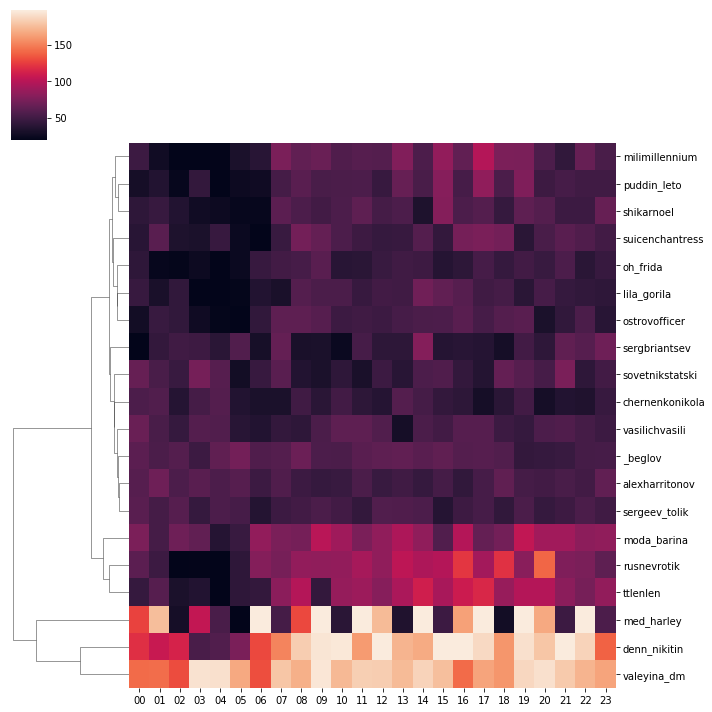

In [740]:
store_hr_cnts_r=defaultdict(list)

for i in user_by_hr_cnt_russ.sort_values(['author','time']).values:
    store_hr_cnts_r[i[1]].append(i[2])
    
d1_r=pd.DataFrame(store_hr_cnts_r,index=sorted(user_by_hr_cnt_russ['author'].unique()))

# I am trying to preserve the HR ordering
sns.clustermap(d1_r,col_cluster=False,robust=True) 

# `What Did We Learn With Russian Reteeters?`

+ Some users have no preference at the top. They may be bots doing retweeting
+ Other users, do have a strong trend

`------------------------------------------------`

# `Show how the Large Retweeters Trickle Down:`

+ Pick two tweets and show activity by plotting

**`Work Flow:`**
+ Take the top 10-20 Re-tweeters
    + Sort By Tweet then user
        + Choose top 10 users for that tweet
+ We will need to see the time of posting these tweets to see who posted first and trickle down from there.

In [742]:
# Get Top 10 Retweeters: English & Russian:
eng_top_10=eng_subset[eng_subset['retweet']==1]['author'].value_counts()[:10]

russ_top_10=russ_subset[russ_subset['retweet']==1]['author'].value_counts()[:10]

# Pull Only Rows with these users:


In [ ]:
eng_subset[eng_subset['retweet']==1]['author'].value_counts()[:10]

In [745]:
eng_subset[eng_subset['retweet']==1]['content without http'].value_counts()[:10]

Listen to the title track of the upcoming mashup album #TheFourHorsemen #TheArtOfWar ft #T…      387
Targeted #ISIS accounts       #targets #iceisis #opiceisis                                       233
Just posted a photo                                                                              155
Targeted #ISIS accounts    #targets #iceisis #opiceisis                                          128
#CommunityEvent Fall Fest on Buddy Holly Ave.  October 29th 2016 #LubbockTexas *1KN              104
Have a hit on your hands? You wont want to miss this!! #SongContest #PushPowerHits                89
I posted a new video to Facebook                                                                  67
6 Reasons Indie Artists Fail                                                                      65
#Юмор@rus_improvisation                                                                           65
�                                                                                          

In [746]:
eng_subset[eng_subset['retweet']==0]['content without http'].value_counts()[:10]

@WarfareWW                                                        104
26 Black Women Who Died In Police Custody                          25
Winning numbers drawn in Triple Chance game                        20
�                                                                  15
AP FACT CHECK: Trump, Clinton and their debate claims               8
El Pasos most wanted fugitives of the week                          7
Winning numbers drawn in Daily 4 Evening game                       7
Berlin truck attack suspect killed in Milan police shootout         6
@todayinsyria                                                       5
Electoral College meets amid effort to deny Trump presidency        5
Name: content without http, dtype: int64

In [750]:
eng_subset.shape[0]

318740

In [757]:
eng_subset['kinda_clean_content']=eng_subset['content without http'].\
str.replace('7yrs','').str.replace(r'(?<=#)[A-Za-z0-9]+','').\
str.replace(r'(?<=@)[A-Za-z0-9]+','').str.strip('[# ]+').str.strip('[@ ]+').\
str.strip(')').str.strip('(').str.strip('-').\
str.strip('lol').str.strip('"').str.strip(u'\u2026').str.strip('#').\
str.lstrip(':').str.strip(' ')

In [752]:
# convert to lowercase(), remove punctuation, symbols
import string

clean_up_more=[]
for i in eng_subset['kinda_clean_content']:

,author,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,content without http,publish_date_Only,time,tweet_ref,hashtag_ref,follower_to_following_Ratio,kinda_clean_content
2299654,richmondvoice,United States,English,2016-10-01 13:49:00,4731,2811,4778,Other_Tweet,local,0,NewsFeed,Chesterfield County Police respond to a wareho...,2016-10-01,13,None,None,0.594166,Chesterfield County Police respond to a wareho...
2299655,richmondvoice,United States,English,2016-10-01 14:16:00,4731,2811,4779,Other_Tweet,local,0,NewsFeed,Petersburg Police investigating after deadly s...,2016-10-01,14,None,None,0.594166,Petersburg Police investigating after deadly s...
2299656,richmondvoice,United States,English,2016-10-01 15:03:00,4731,2811,4781,Other_Tweet,local,0,NewsFeed,Flint Residents On Federal Aid Deal: Too Littl...,2016-10-01,15,None,None,0.594166,Flint Residents On Federal Aid Deal: Too Littl...
2299657,richmondvoice,United States,English,2016-10-01 15:06:00,4731,2811,4782,Other_Tweet,local,0,NewsFeed,Mob informant trades witness protection for $1...,2016-10-01,15,None,None,0.594166,Mob informant trades witness protection for $100M
2299658,richmondvoice,United States,English,2016-10-01 15:33:00,4731,2811,4783,Other_Tweet,local,0,NewsFeed,Man found dead outside Petersburg home,2016-10-01,15,None,None,0.594166,Man found dead outside Petersburg home


In [268]:
# Top 10 retweeters in english:
# eng_ppl=list(eng_subset[eng_subset['retweet']==1]['author'].value_counts()[:200].index)
# eng_subset[eng_subset['author'].isin(eng_ppl)==True]['content without http'].value_counts()[:30]

# <font color=red>Like</font>, Share &

# <font color=red>SUB</font>scribe

<font size=5>**`Help Support The Channel: Patreon @mrfugudatasci`**</font>
    
**`Consider Also: Buy Me A Coffee @mrfugudatasci`**

# `Citations & Help:`

# ◔̯◔

https://www.kaggle.com/auntiebody/coordinating-influence-on-twitter (very good notebook)

https://www.kaggle.com/laurenliz22/russian-troll-tweets (other motivation)

https://cmdlinetips.com/2020/01/heatmaps-with-seaborns-clustermap/

https://pythontic.com/visualization/seaborn/clustermap

https://inst.eecs.berkeley.edu/~cs61b/su06/lecnotes/lec28.pdf